## Measure-Preserving Systems

Measure-preserving systems obey the Poincaré recurrence theorem, and are a special case of conservative systems. They provide the formal, mathematical basis for a broad range of physical systems, and, in particular, many systems from classical mechanics (in particular, most non-dissipative systems) as well as systems in thermodynamic equilibrium.

We wish to discover if there is a relationship between the dissipative element of a system and the utility of eigenvalue penalties and initialisation. That is, if we are able to capture the non-dissipative element for prediction.

### Damped Driven Pendulum

We hypothesis that as the damping increases, the utility of the penalty and initialisation will increase.

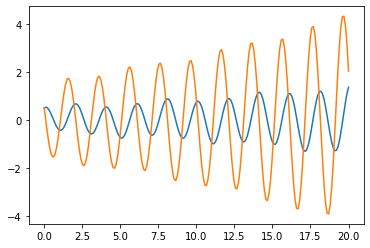

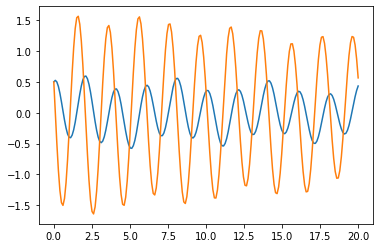

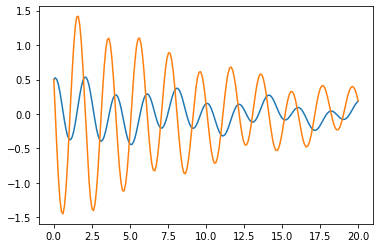

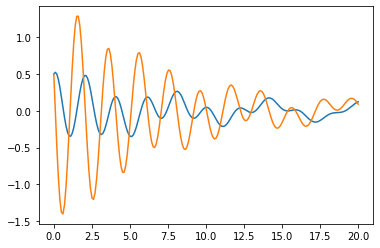

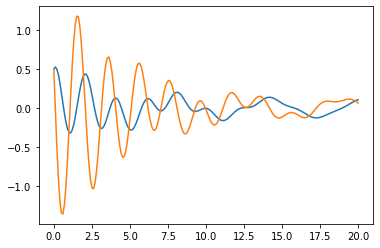

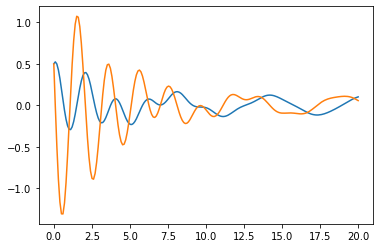

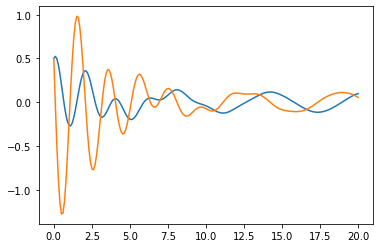

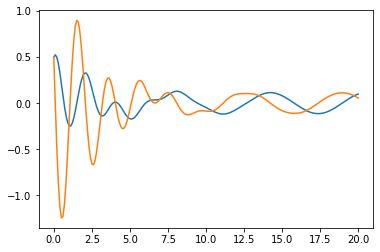

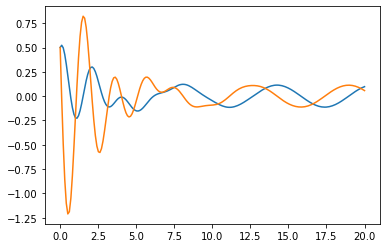

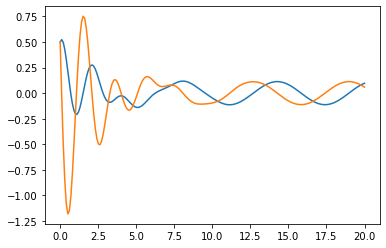

In [26]:
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import numpy as np

def simple_pendulum_deriv(x, t, m, g, l, F, c, omega): 
# The simple pendulum subject to zero damping and zero control input 
    nx = np.zeros(2)
    nx[0] = x[1]
    nx[1] = (1/m) * (F * math.sin(omega * t) - (m * g / l) * x[0] - c * nx[0])
    return nx

for c in np.linspace(-0.6, 0.6, 10):
    t_span = np.linspace(0,20,200)

    sol = odeint(simple_pendulum_deriv, y0=[0.5,0.5], t=t_span, args=(1,9.8,1,1,0.5+c,1))
    y = sol[:,0]
    y_dot = sol[:,1]
    plt.plot(t_span, y)
    plt.plot(t_span, y_dot)
    plt.show()

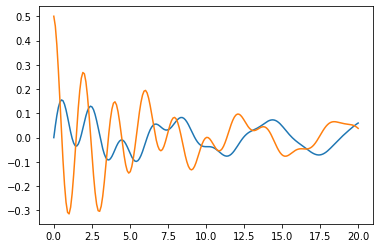

In [2]:
plt.plot(t_span, y)
plt.plot(t_span, y_dot)
plt.show()

In [110]:
ls /g/data/x77/jm0124/synthetic_datasets

base_synthesis/                 pendulum_dissipative-0.6-10.npy
gan_perturb_synthesis/          pendulum_dissipative-1.0-5.npy
normal_perturb_synthesis/       pendulum_dissipative_test.npy
pendulum_dissipative/           pendulum_dissipative_train.npy
pendulum_dissipative-0.2-5.npy  pendulum_dissipative_valid.npy
pendulum_dissipative-0.5-5.npy


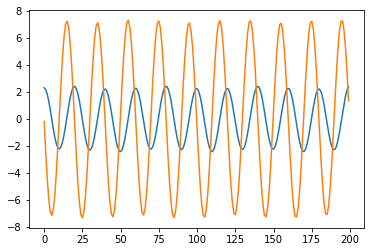

In [49]:
loaded_synth = np.load("/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative-0.6-10.npy")
plt.plot(loaded_synth[0][8640])

In [ ]:
np.random.shuffle(loaded_synth)
training, val, test = loaded_synth[:,:7000], loaded_synth[:,7000:8500], loaded_synth[:,8500:10000]

In [ ]:
np.save('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_train.npy', training)
np.save('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_valid.npy', val)
np.save('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_test.npy', test)

In [ ]:
import torch
from torch.utils.data import Dataset

class PendulumToPendulum(Dataset):
    def __init__(self, prediction_length, dissipation_level, partition_name='train'):
        self.pendulum_array = np.load(f"/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_{partition_name}.npy")
        self.dissipation_level = dissipation_level
        self.prediction_length = prediction_length
    
    def __len__(self):
        return self.pendulum_array.shape[1]
    
    def __getitem__(self, idx):
        i = 0
        for pend_run in self.pendulum_array[self.dissipation_level]:
            j = self.prediction_length
            for time_step in pend_run[self.prediction_length:-self.prediction_length]:
                if i == idx:
                    return pend_run[j-self.prediction_length:j+self.prediction_length]
                j += 1
                i += 1

In [136]:
pend_ds = PendulumToPendulum(4, 0, 'valid')

### Testing Cyclone Examples

There is a known result that if the divergence of vector fields are non-zero the system is not measure preserving.

In [1]:
import xarray
import metpy.calc
import windspharm.xarray

In [2]:
import json
train_json_path = '/g/data/x77/ob2720/partition/train.json'

with open(train_json_path, 'r') as tj:
    tj_dict = json.load(tj)

In [3]:
divs = []
for i, (cyclone, data) in enumerate(tj_dict.items()):
    if i % 250 == 0:
        cyclone_coords = tj_dict[cyclone]['coordinates']
        ds = xarray.open_mfdataset(f"/g/data/x77/ob2720/partition/train/{cyclone}.nc")
        u = ds.u[dict(time=int(len(ds.time)/2), level=2)]
        v = ds.v[dict(time=int(len(ds.time)/2), level=2)]
        new_lat = u.latitude/4 + cyclone_coords[int(len(ds.time)/2)][1] - 20
        new_lon = u.longitude/4 + cyclone_coords[int(len(ds.time)/2)][0] - 20
        dx, dy = metpy.calc.lat_lon_grid_deltas(longitude=new_lon.values, latitude=new_lat.values)
        div = metpy.calc.divergence(u, v, dx=dx, dy=dy)
        divs.append(div.values * 10800)

In [4]:
import seaborn

<AxesSubplot:>

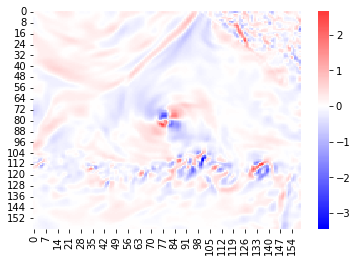

In [5]:
seaborn.heatmap(divs[1], cmap='bwr', center=0)

In [107]:
divs[0].sum()

197.70461062260736

Here, we have shown that over the 3h timescale of prediction used, the divergence of the system is clearly non-zero for a random selection of cyclone examples.

### Kuramoto–Sivashinsky equation

In mathematics, the Kuramoto–Sivashinsky equation (also called the KS equation or flame equation) is a fourth-order nonlinear partial differential equation. It is named after Yoshiki Kuramoto and Gregory Sivashinsky, who derived the equation in the late 1970s to model the diffusive–thermal instabilities in a laminar flame front

[  0.    1.5   3.    4.5   6.    7.5   9.   10.5  12.   13.5  15.   16.5
  18.   19.5  21.   22.5  24.   25.5  27.   28.5  30.   31.5  33.   34.5
  36.   37.5  39.   40.5  42.   43.5  45.   46.5  48.   49.5  51.   52.5
  54.   55.5  57.   58.5  60.   61.5  63.   64.5  66.   67.5  69.   70.5
  72.   73.5  75.   76.5  78.   79.5  81.   82.5  84.   85.5  87.   88.5
  90.   91.5  93.   94.5  96.   97.5  99.  100.5 102.  103.5 105.  106.5
 108.  109.5 111.  112.5 114.  115.5 117.  118.5 120.  121.5 123.  124.5
 126.  127.5 129.  130.5 132.  133.5 135.  136.5 138.  139.5 141.  142.5
 144.  145.5 147.  148.5 150. ]
[0.00390625 0.0078125  0.01171875 0.015625   0.01953125 0.0234375
 0.02734375 0.03125    0.03515625 0.0390625  0.04296875 0.046875
 0.05078125 0.0546875  0.05859375 0.0625     0.06640625 0.0703125
 0.07421875 0.078125   0.08203125 0.0859375  0.08984375 0.09375
 0.09765625 0.1015625  0.10546875 0.109375   0.11328125 0.1171875
 0.12109375 0.125      0.12890625 0.1328125  0.13671875 0

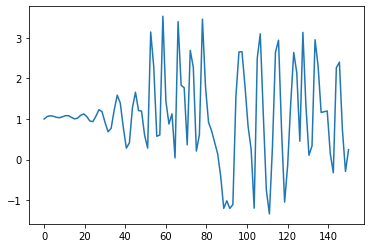

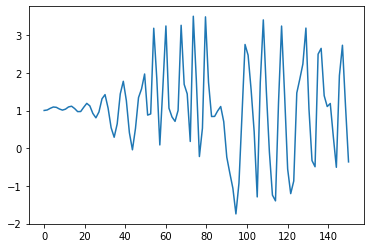

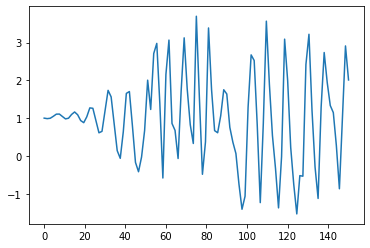

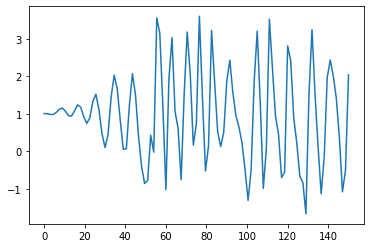

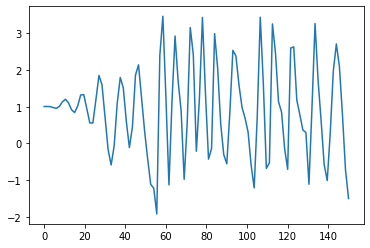

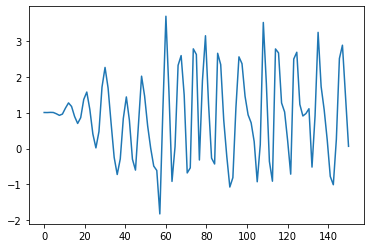

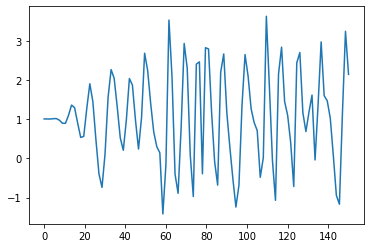

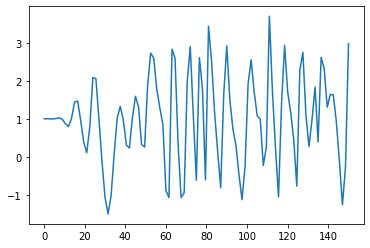

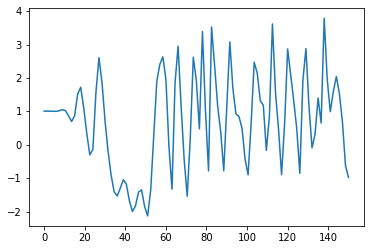

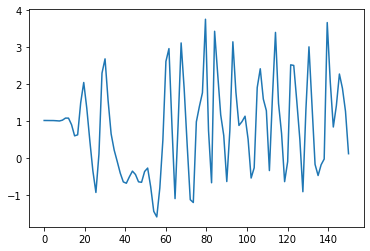

/jobfs/44236404.gadi-pbs/ipykernel_2751501/2044018009.py:70: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


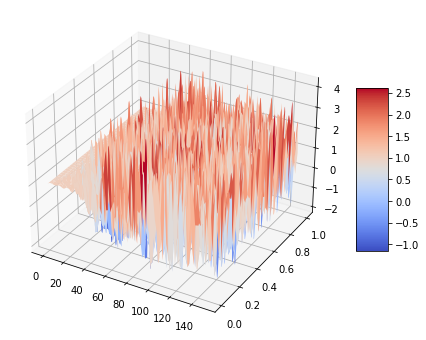

In [167]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# KSequ.m - solution of Kuramoto-Sivashinsky equation
#
# u_t = -u*u_x - u_xx - u_xxxx, periodic boundary conditions on [0,32*pi]
# computation is based on v = fft(u), so linear term is diagonal
#
# Using this program:
# u is the initial condition
# h is the time step
# N is the number of points calculated along x
# a is the max value in the initial condition
# b is the min value in the initial condition
# x is used when using a periodic boundary condition, to set up in terms of
#   pi
#
# Initial condition and grid setup
N = 256
x = np.transpose(np.conj(np.arange(1, N+1))) / N
a = -1
b = 1
u = np.cos(x/16)*(1+np.sin(x/16))
v = np.fft.fft(u)
# scalars for ETDRK4
h = 0.25
k = np.transpose(np.conj(np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0))))) / 16
L = k**2 - k**4
E = np.exp(h*L)
E_2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.transpose(np.repeat([L], M, axis=0)) + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
# main loop
uu = np.array([u])
tt = 0
tmax = 150
nmax = round(tmax/h)
nplt = int((tmax/100)/h)
g = -0.5j*k
for n in range(1, nmax+1):
    t = n*h
    Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E_2*v + Q*Nv
    Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E_2*v + Q*Na
    Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E_2*a + Q*(2*Nb-Nv)
    Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))

print(tt)
print(x)

for i in range(0,10):
    plt.plot(tt, uu.transpose()[i*5])
    plt.show()
        # plot
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
tt, x = np.meshgrid(tt, x)
surf = ax.plot_surface(tt, x, uu.transpose(), cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()